<a href="https://colab.research.google.com/github/wangsongyuan98/simple_trading_strategy/blob/main/stochastic_rsi_macd_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install yfinance &> /dev/null

In [100]:
!pip install ta &> /dev/null

In [101]:
import yfinance as yf
import numpy as np
import ta
import pandas as pd

In [129]:
df = yf.download('BTC-USD', start='2021-08-20', interval='30m')

[*********************100%***********************]  1 of 1 completed


In [130]:
df.shape

(2727, 6)

The Formula for the Stochastic Oscillator Is
\begin{aligned} &\text{\%K}=\left(\frac{\text{C} - \text{L14}}{\text{H14} - \text{L14}}\right)\times100\\ &\textbf{where:}\\ &\text{C = The most recent closing price}\\ &\text{L14 = The lowest price traded of the 14 previous}\\ &\text{trading sessions}\\ &\text{H14 = The highest price traded during the same}\\ &\text{14-day period}\\ &\text{\%K = The current value of the stochastic indicator}\\ \end{aligned} 
​
  
%K=( 
H14−L14
C−L14
​
 )×100
where:
C = The most recent closing price
L14 = The lowest price traded of the 14 previous
trading sessions
H14 = The highest price traded during the same
14-day period
%K = The current value of the stochastic indicator
​


k line

In [131]:
df['%K'] = ta.momentum.stoch(df.High, df.Low, df.Close, window=14, smooth_window=3) #Stochastic Oscillator https://www.investopedia.com/terms/s/stochasticoscillator.asp

d line, stochastic sold

In [132]:
df['%D'] = df['%K'].rolling(3).mean()

In [133]:
df['rsi'] = ta.momentum.rsi(df.Close, window = 14)

In [134]:
df['macd'] = ta.trend.macd_diff(df.Close)

In [135]:
df.dropna(inplace= True)

create trigger signal

In [136]:
def get_triggers(df, lags, buy=True): #lags = number of time steps we want to go back
  dfx = pd.DataFrame()
  for i in range(1,lags+1):
    if buy:
      mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20) 
    else: #sold
      mask = (df['%K'].shift(i) > 80) & (df['%D'].shift(i) > 80) 

    dfx = dfx.append(mask, ignore_index=True)
  return dfx.sum(axis=0)

In [137]:
get_triggers(df,4)

2021-08-20 17:30:00+01:00    0.0
2021-08-20 18:00:00+01:00    0.0
2021-08-20 18:30:00+01:00    0.0
2021-08-20 19:00:00+01:00    0.0
2021-08-20 19:30:00+01:00    0.0
                            ... 
2021-10-15 18:00:00+01:00    0.0
2021-10-15 18:30:00+01:00    0.0
2021-10-15 19:00:00+01:00    0.0
2021-10-15 19:30:00+01:00    0.0
2021-10-16 00:00:00+01:00    0.0
Length: 2694, dtype: float64

In [138]:
np.where(get_triggers(df,4),1,0)

array([0, 0, 0, ..., 0, 0, 0])

In [139]:
df['buy_tr'] = np.where(get_triggers(df,4),1,0) #get trigger = 1, if no trigger = 0

In [140]:
df['sell_tr'] = np.where(get_triggers(df,4, False),1,0) #get trigger = 1, if no trigger = 0

In [141]:
df['buy'] = np.where(df['buy_tr'] & (df['%K'].between(20,80) & df['%D'].between(20,80)) & (df.rsi > 50) & (df.macd > 0), 1, 0)

In [142]:
df['sell'] = np.where(df['sell_tr'] & (df['%K'].between(20,80) & df['%D'].between(20,80)) & (df.rsi <= 50) & (df.macd <= 0), 1, 0)  #how about <=

In [143]:
buying_dates, selling_dates = [],[]

In [144]:
for i in range(len(df) - 1):
  if df['buy'].iloc[i]: #access the buy data on that row
    buying_dates.append(df.iloc[i+1].name)
    for num, j in enumerate(df['sell'][i:]):
      if j: #1
        selling_dates.append(df.iloc[i+num + 1].name) #next row
        break


avoid meaningless or multiple position

In [145]:
cutit = len(buying_dates) - len(selling_dates)

In [146]:
if cutit:
  buying_dates = buying_dates[:-cutit]

In [147]:
frame = pd.DataFrame({'buying_dates':buying_dates, 'selling_dates':selling_dates})
frame

,buying_dates,selling_dates
0,2021-08-28 23:30:00+01:00,2021-08-29 13:00:00+01:00
1,2021-09-05 09:30:00+01:00,2021-09-09 19:30:00+01:00
2,2021-09-12 04:30:00+01:00,2021-09-16 11:00:00+01:00
3,2021-09-12 05:00:00+01:00,2021-09-16 11:00:00+01:00
4,2021-09-22 15:00:00+01:00,2021-09-25 13:00:00+01:00
5,2021-10-08 07:00:00+01:00,2021-10-10 02:30:00+01:00
6,2021-10-11 02:30:00+01:00,2021-10-12 11:00:00+01:00
7,2021-10-11 03:00:00+01:00,2021-10-12 11:00:00+01:00
8,2021-10-11 03:30:00+01:00,2021-10-12 11:00:00+01:00


In [148]:
actuals = frame[frame.buying_dates > frame.selling_dates.shift(1)] #shift allow us to go to the next row

In [149]:
actuals

,buying_dates,selling_dates
1,2021-09-05 09:30:00+01:00,2021-09-09 19:30:00+01:00
2,2021-09-12 04:30:00+01:00,2021-09-16 11:00:00+01:00
4,2021-09-22 15:00:00+01:00,2021-09-25 13:00:00+01:00
5,2021-10-08 07:00:00+01:00,2021-10-10 02:30:00+01:00
6,2021-10-11 02:30:00+01:00,2021-10-12 11:00:00+01:00


In [150]:
def profitcalc():
  buyprices = df.loc[actuals.buying_dates]['Open']
  sellprices = df.loc[actuals.selling_dates]['Open']
  return (sellprices.values - buyprices.values)/buyprices.values

In [151]:
profits = profitcalc()
profits

array([-0.06567695,  0.0577012 ,  0.00356852,  0.00789607,  0.02537738])

In [152]:
(profits + 1).prod()


1.0249591775117632

LOOKS OK

In [153]:
import matplotlib.pyplot as plt


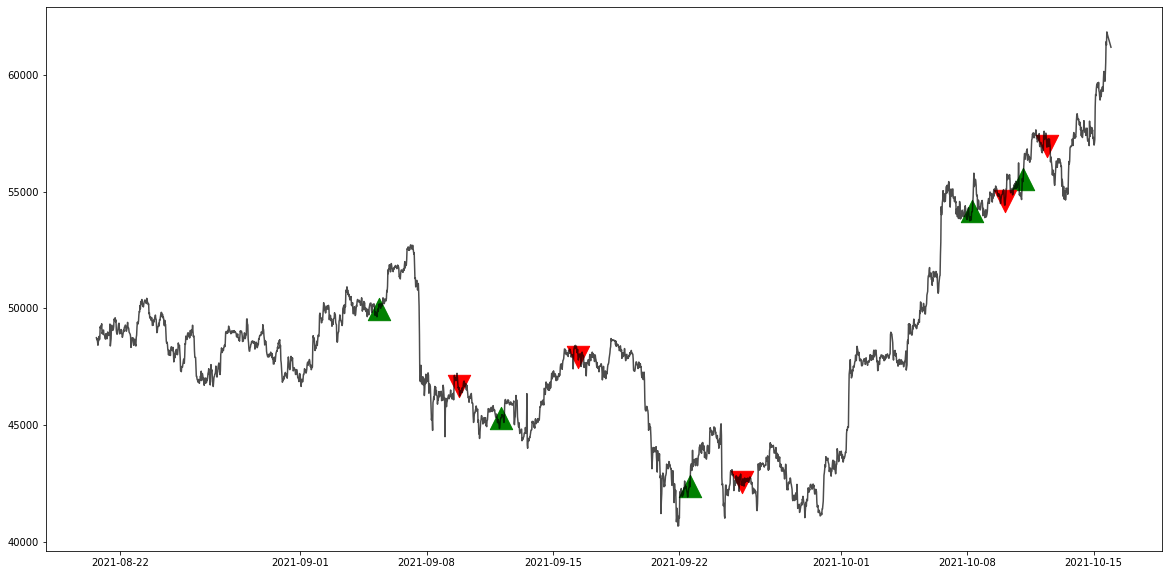

In [154]:
plt.figure(figsize=(20,10))
plt.plot(df.Close, color = 'k', alpha = 0.7)
plt.scatter(actuals.buying_dates, df.Open[actuals.buying_dates], marker='^', color= 'g', s=500)
plt.scatter(actuals.selling_dates, df.Open[actuals.selling_dates], marker='v', color= 'r', s=500)